In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [46]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 
results = results[results['Query Name'] == "Pandas Converted (Hyper DB)"]

In [47]:
duck_results = pd.read_csv("../test_results/duck_pandas_uplan.csv") 

In [48]:
results = pd.concat([results, duck_results], ignore_index=True)

In [49]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 26
Correct Results: 26


In [50]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [54]:
def make_compare_graph(df, order, color, filename):
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    # sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 1.0
    plt.rcParams['patch.edgecolor'] = 'k'
    
    plt.rc('axes', labelsize=12)    # fontsize of the x and y labels

    ax = sns.barplot(data=df, x='Query Number', y='Mean', hue='Query Type',
                     palette=color, hue_order=order)

    # ax.set_yscale("log")
    ax.set(xlabel='Query', ylabel='Mean Runtime (ms)')

    # Make axes weightier
    plt.setp(ax.spines.values(), linewidth=2)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major')
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=10)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True, fontsize=14)

    ax.spines[['right', 'top']].set_visible(False)
    
    ax.patch.set_alpha(0.0)
    
    plt.tight_layout()

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [52]:
results['Mean'] = results['Mean'].apply(lambda x : x * 1000)
results['Query Type'] = results['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas (Hyper DB)',
        'Pandas Converted (Duck DB)': 'Pandas (Duck DB)'
     }
)

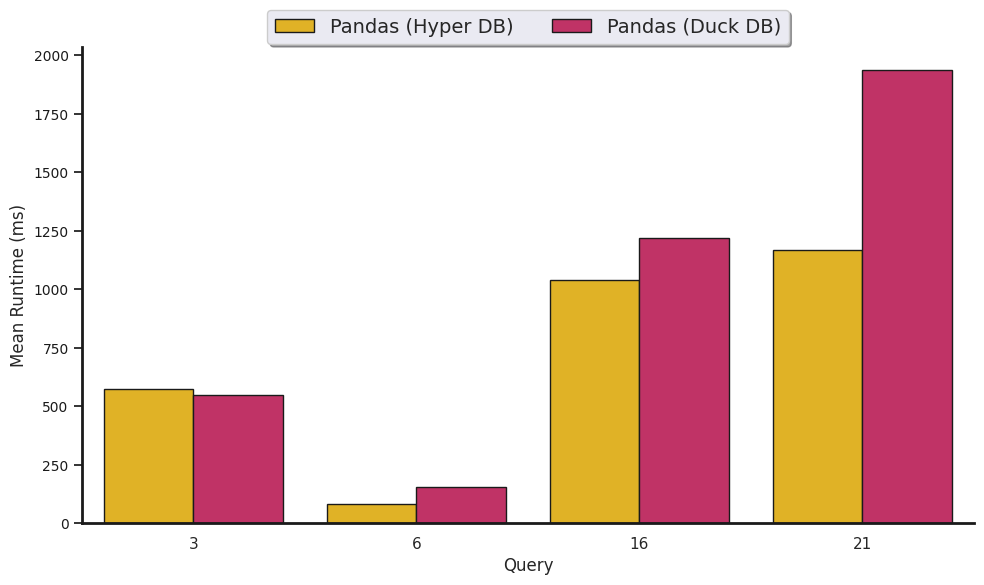

In [55]:
current_df = results[results["Query Number"].isin([3, 6, 16, 21])]
pg_order = ["Pandas (Hyper DB)", "Pandas (Duck DB)"]
pg_color = ['#FFC107','#D81B60']
pg_filename = "../analysis_results/y2_report/TransformationRulesHyperDuck.pdf"

make_compare_graph(current_df, pg_order, pg_color, pg_filename)
